In [1]:
from statistics import mean, stdev
from plotnine import *
import pandas as pd
import statsmodels.formula.api as sm

# Elections Analysis

## Data Documentation: Spain 2011 National Elections

![](../resources/2011_Spanish_election_-_Results.svg)
> Image from Wikimedia

## Context

On the 20th of November 2011. Spain held an election for the Cortes Generales, the equivalent of Parliament or Congress in other countries. This election was held in all the municipalities of the Country and it had a turnout of 24.6 million people, around 68.9% of the population at the moment. However, this election is historic in that it was the largest loss a sitting government had been subjected to since 1982 as the Socialist Party lost the election and the People's Party rose to power.

## This dataset

This dataset contains a sample of the Galice and Madrid communities from a full dataset published by the Ministry of the Interior of Spain. Each observation in the dataset represents a precinct within a municipality. The geographical hierarchy is as follows {Community --> Province --> Municipality --> Precinct}.

The columns of the dataset are the following:

| Column | Description |
|:------:|:-----------:|
| community | Community (GALICIA or MADRID) |
| province | Province within Community (5 levels) |
| municipality | Municipality within Province (495 levels) |
| precinct | The precinct within the municipality |
| registeredVoters | The number of registered voters |
| emptyBallots | The number of empty ballots, these count as valid ballots |
| invalidBallots| The number of invalid ballots |
| validBallots | The number of valid ballots, includes the number of empty ballots |
| ballotsLeader| The number of votes for the Leader |

In [3]:
data = pd.read_csv('../data/spain_elections_subset_2011.csv')
data.head()

,community,province,municipality,precinct,registeredVoters,emptyBallots,invalidBallots,validBallots,ballotsLeader
0,GALICIA,"Coruña, A",Ames,001 B,270,3,7,206,129
1,GALICIA,"Coruña, A",Ames,004 A,356,2,7,257,136
2,GALICIA,"Coruña, A",Ames,002 C,296,1,2,214,149
3,GALICIA,"Coruña, A",Ames,010 U,646,15,10,507,189
4,GALICIA,"Coruña, A",Ames,012 B,695,6,8,479,247


## Municipalities and Precincts

Our analisis consists of two components, the first one focused on exploratory data analysis of municipalities and precincts and the second one focused on statistical analysis of the voting patterns of voters. We want to start our first analysis by counting the number of precincts by province. This will help us know the balance of our dataset which will be important once we start doing statistical analysis.

In [4]:
data.groupby('precinct').size()

precinct
0000U      5
001 A    622
001 B    622
001 C    150
001 D     18
        ... 
218 U      1
219 A      1
219 B      1
220 A      1
220 B      1
Length: 678, dtype: int64

We also want to see how many municipalities had more invalid ballots than empty ballots. We track this information in each election as it allows us to identify which areas need further education campaigns about the different voting mechanisms. 

In [5]:
len(data.query('emptyBallots < invalidBallots'))

,community,province,municipality,precinct,registeredVoters,emptyBallots,invalidBallots,validBallots,ballotsLeader
0,GALICIA,"Coruña, A",Ames,001 B,270,3,7,206,129
1,GALICIA,"Coruña, A",Ames,004 A,356,2,7,257,136
2,GALICIA,"Coruña, A",Ames,002 C,296,1,2,214,149
4,GALICIA,"Coruña, A",Ames,012 B,695,6,8,479,247
6,GALICIA,"Coruña, A",Aranga,002 B,233,1,2,189,133
...,...,...,...,...,...,...,...,...,...
10558,MADRID,Madrid,Valdemoro,006 A,678,1,7,482,294
10560,MADRID,Madrid,Valdemoro,017 A,663,3,4,483,262
10561,MADRID,Madrid,Valdemoro,017 B,721,8,9,508,281
10563,MADRID,Madrid,Valdemoro,001 B,544,3,5,383,193


Now that we know how many municipalities had more invalid ballots than valid balots, we want to identify those municipalities in which the leader in the ballots gained the majority of the votes for a given area. We are defining the majority as a simple majority (50% + 1) of the registered voters for that area.

In [5]:
data.query('ballotsLeader < registeredVoters')

,community,province,municipality,precinct,registeredVoters,emptyBallots,invalidBallots,validBallots,ballotsLeader
0,GALICIA,"Coruña, A",Ames,001 B,270,3,7,206,129
1,GALICIA,"Coruña, A",Ames,004 A,356,2,7,257,136
2,GALICIA,"Coruña, A",Ames,002 C,296,1,2,214,149
3,GALICIA,"Coruña, A",Ames,010 U,646,15,10,507,189
4,GALICIA,"Coruña, A",Ames,012 B,695,6,8,479,247
...,...,...,...,...,...,...,...,...,...
10565,MADRID,Madrid,Velilla de San Antonio,006 U,728,13,8,564,301
10566,MADRID,Madrid,Villaconejos,001 A,719,6,6,458,251
10567,MADRID,Madrid,Villalbilla,002 A,872,7,1,680,418
10568,MADRID,Madrid,Villanueva de la Cañada,001 B,865,10,10,693,454


One of the caveats of dealing with data from hispanic countries is that it usually comes with accents and special characters not available in the English language. We want to have our data as standardized as possible as we will later be joining the dataset with spatial data from the European Union. For this we want to replace the `ñ` character with the `n` character in the `municipality` column.

In [6]:
data['municipality'].str.replace('ñ', 'n')

0                           Ames
1                           Ames
2                           Ames
3                           Ames
4                           Ames
                  ...           
10565     Velilla de San Antonio
10566               Villaconejos
10567                Villalbilla
10568    Villanueva de la Canada
10569                Tres Cantos
Name: municipality, Length: 10570, dtype: object

As the final component of our Exploratory Data Analysis focused on Municipalities and Precincts we want to find the top 5 precincts in each community that are strongholds for the ballot leader. We are defining a stronghold as a community that deviates two standard deviations from the mean support of the ballot leader.

In [7]:
grouped = data.assign(
    pct_leader = data['ballotsLeader']/data['validBallots']
).groupby('community')

for name, group in grouped:
    group = group.assign(
        mean_pct_leader = lambda x: mean(x['pct_leader']),
        sd_pct_leader = lambda x: stdev(x['pct_leader']),
        up_pct_leader = lambda x: x['mean_pct_leader']+2*x['sd_pct_leader']
    )
    display(group.query('pct_leader > up_pct_leader')[0:5])

,community,province,municipality,precinct,registeredVoters,emptyBallots,invalidBallots,validBallots,ballotsLeader,pct_leader,mean_pct_leader,sd_pct_leader,up_pct_leader
17,GALICIA,"Coruña, A",Cabana de Bergantiños,001 B,375,3,5,281,218,0.775801,0.546047,0.110551,0.767148
34,GALICIA,"Coruña, A",Aranga,001 B,266,3,4,189,150,0.793651,0.546047,0.110551,0.767148
210,GALICIA,"Coruña, A",Cerdido,001 C,483,2,2,340,273,0.802941,0.546047,0.110551,0.767148
410,GALICIA,"Coruña, A",Mazaricos,003 U,622,2,1,463,358,0.773218,0.546047,0.110551,0.767148
470,GALICIA,"Coruña, A",Melide,006 A,377,2,6,263,215,0.817490,0.546047,0.110551,0.767148


,community,province,municipality,precinct,registeredVoters,emptyBallots,invalidBallots,validBallots,ballotsLeader,pct_leader,mean_pct_leader,sd_pct_leader,up_pct_leader
2771,MADRID,Madrid,Alcobendas,034 U,801,4,1,665,581,0.873684,0.511132,0.113881,0.738895
3056,MADRID,Madrid,Alcobendas,039 C,630,5,4,514,400,0.778210,0.511132,0.113881,0.738895
3128,MADRID,Madrid,Alcobendas,059 B,662,7,0,549,476,0.867031,0.511132,0.113881,0.738895
3201,MADRID,Madrid,Alcobendas,035 U,544,1,0,442,401,0.907240,0.511132,0.113881,0.738895
3240,MADRID,Madrid,Colmenar de Oreja,001 U,936,5,10,675,500,0.740741,0.511132,0.113881,0.738895


## Voters

The second part of the analysis focuses on statistical analysis of the voting patterns at different geographic levels. However to get a grasp of the data we are handling we first visualize the total number of registered voters per community.

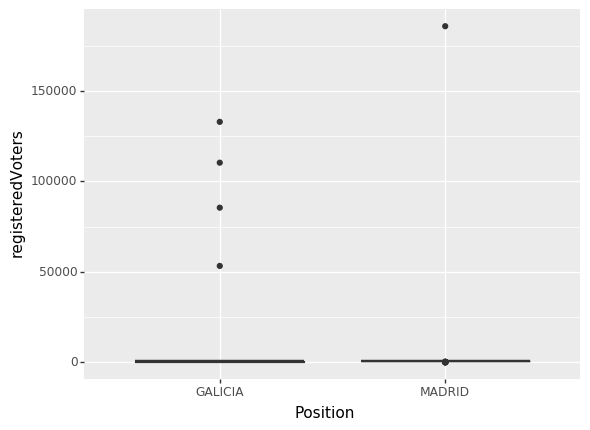

<ggplot: (8767120038777)>

In [4]:
chart = (ggplot(data, aes(x = 'community', y = 'registeredVoters'))
          + geom_boxplot()
          + xlab('Position'))
display(chart)

With this visualization in perspective, as it informs us about the sample sizes for each community, we know want to explore the distribution of the percentage of people that voted for the leader in each community.

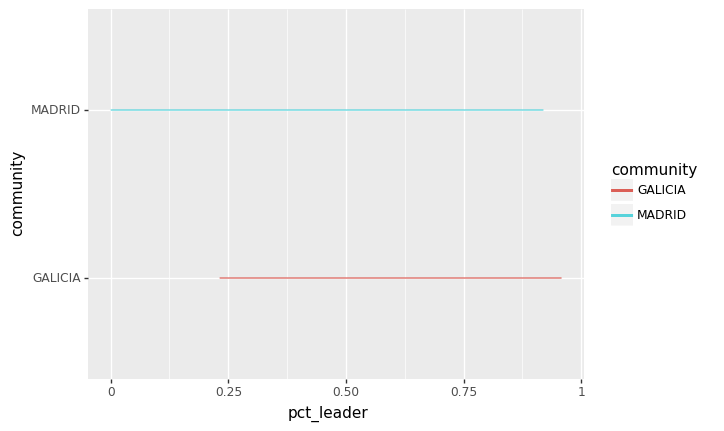

<ggplot: (8767119788561)>

In [5]:
chart = (ggplot(data.assign(pct_leader = data['ballotsLeader']/data['validBallots'])
                , aes(x = 'pct_leader', y = 'community', color = 'community'))
        + geom_line())

display(chart)

We can see that both communities have similar voting patterns and distributions. However, given this, we want to know if at a more granular scale such as province within a given community, the province has an effect on the amount of ballots a leader would get. For this we will test if there is an association between the province and the number of votes the leader received with a linear regression.

In [10]:
model = sm.ols(
    formula="ballotsLeader ~ province", 
    data=data[data['community'] == 'GALICIA']
).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ballotsLeader   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.858
Date:                Fri, 31 Jul 2020   Prob (F-statistic):             0.0356
Time:                        15:25:30   Log-Likelihood:                -24126.
No. Observations:                4041   AIC:                         4.826e+04
Df Residuals:                    4037   BIC:                         4.829e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                218.6433      2.393     91.376      0.000     213.952     223.334
province[T.Lugo]          -3.7371      4.651     -0.803      0.422     -12.856       5.382
province[T.Ourense]      -12.2333      4.664     -2.623      0.009     -21.376      -3.090
province[T.Pontevedra]    -7.4322      3.523     -2.110      0.035     -14.338      -0.526
==============================================================================
Omnibus:                     5877.704   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5628190.807
Skew:                           8.245   Prob(JB):                         0.00
Kurtosis:                     185.084   Cond. No.                         4.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> There was no association at all found between any of the provinces and the number of votes.

As a complement to this regression, we want to see the relationship between the percentage of people who voted for the leader and the percentage who voted in each precinct. This will let us test the hypothesis that precincts with higher abstention rates are associated with lower support for the leader. We believe the method implemented below does this correctly.

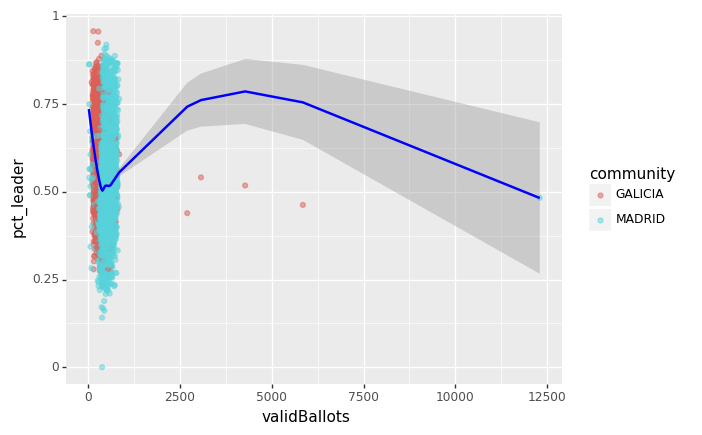

<ggplot: (8767120081349)>

In [6]:
chart = (ggplot(data.assign(pct_leader = data['ballotsLeader']/data['validBallots'],
                           pct_voted = (data['validBallots'] + data['invalidBallots'])/data['registeredVoters'])
                , aes(x = 'validBallots', y = 'pct_leader', color = 'community'))
        + geom_point(alpha= 0.5)
        + geom_smooth(method = 'loess', color = 'blue'))

display(chart)

As a final analysis, we want to explore if there is a linear relationship between the number of registered voters in a precinct and the number of invalid ballots. We understand that the regression implemented fits correctly the assumptions of it's methods.

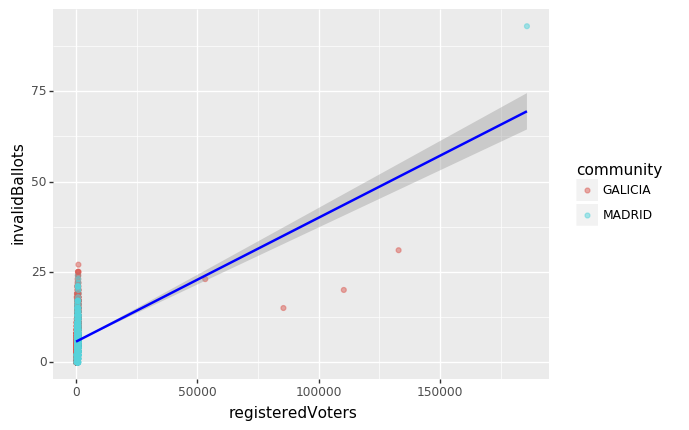

<ggplot: (8767120881765)>

In [9]:
chart = (ggplot(data, aes(x = 'registeredVoters', y = 'invalidBallots', color = 'community'))
        + geom_point(alpha= 0.5)
        + stat_smooth(color = 'blue'))

display(chart)